# Installing packages

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from scipy.stats.stats import pearsonr  
from scipy import stats
from sklearn.metrics import r2_score
from itertools import combinations

%load_ext rpy2.ipython

/var/folders/yr/1hvrtjdn3hzc_7rf_6kpdl69v063g3/T/ipykernel_64012/4259127624.py:6: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [3]:
%%R  -w 8 -h 3 #--units in -r 200
##installing packages and setting options for the plots in R

# {r settings, echo=F, message=F, error=F}
knitr::opts_chunk$set(echo = F)
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggplot2, patchwork, cowplot, tidyverse, devtools, ggrepel, ggh4x, officer, rvg, svglite, install = T)

# # Required on the first run, comment afterward?
devtools::install_github("BlakeRMills/MoMAColors")
library(MoMAColors)

theme_set(theme_cowplot() +
          theme(text = element_text(size=9),
                axis.text = element_text(size=9),
                panel.grid.major.x = element_blank() ,
                panel.grid.major.y = element_line( linewidth=.1, color="black")))

Loading required package: pacman
Using GitHub PAT from the git credential store.
Skipping install of 'MoMAColors' from a github remote, the SHA1 (6f5d75de) has not changed since last install.
  Use `force = TRUE` to force installation


# Models

In [4]:
def get_probs_max(add_cost, mult_cost, f1):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1    
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] = max(number_probs[i],number_probs[j]*number_probs[i-j]*add_cost) 
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i]= max(number_probs[i],number_probs[j]*number_probs[i//j]*mult_cost)
    return np.log10(number_probs[1:100])
def get_probs_add(add_cost, mult_cost, f1):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1    
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] += number_probs[j]*number_probs[i-j]*add_cost  
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i] += number_probs[j]*number_probs[i//j]*mult_cost
    return np.log10(number_probs[1:100])


def loss_function_max(params, target_vector):
    add_cost, mult_cost, f1 = params
    predictions = get_probs_max(add_cost, mult_cost, f1)
    return np.sum((predictions - target_vector) ** 2)

def loss_function_add(params, target_vector):
    add_cost, mult_cost, f1 = params
    predictions = get_probs_add(add_cost, mult_cost, f1)
    return np.sum((predictions - target_vector) ** 2)

In [5]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['en'])]
target = np.array(df['log_freq'])
freqs = df.corrected_total_freq
## we define the initial guess for the optimization as what would be 
##the parameters accounting for the first few numbers
## so that the initial guess is in the right neigborhood
initial_guess = [freqs[1]/freqs[0]/freqs[0], freqs[5]/freqs[1]/freqs[2], freqs[0]]
##            = freq(2)/freq(1)^2             , freq(6)/(freq(2)*freq(3))    , freq(1) 


result_max = minimize(loss_function_max, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params_max = result_max.x
predictions_max = get_probs_max(*best_params_max)
R2_max = (r2_score(predictions_max,df.log_freq))

result_add = minimize(loss_function_add, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params_add = result_add.x
predictions_add = get_probs_add(*best_params_add)
R2_add = (r2_score(predictions_add,df.log_freq))

numbers = [i+1 for i in range(99)]
preds = {
    'numbers':numbers,
    'log_freq': df.log_freq,
    'predictions_max':predictions_max,
    'predictions_add':predictions_add,

    'R2':[R2_max, R2_add] + [0]*(len(numbers)-2)

}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

In addition: Warning messages:
1: `guide_axis_manual()` was deprecated in ggh4x 0.3.0.
ℹ Please use `legendry::guide_axis_base()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
2: The S3 guide system was deprecated in ggplot2 3.5.0.
ℹ It has been replaced by a ggproto system that can be extended.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
3: `is.ggproto()` was deprecated in ggplot2 3.5.2.
ℹ Please use `is_ggproto()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


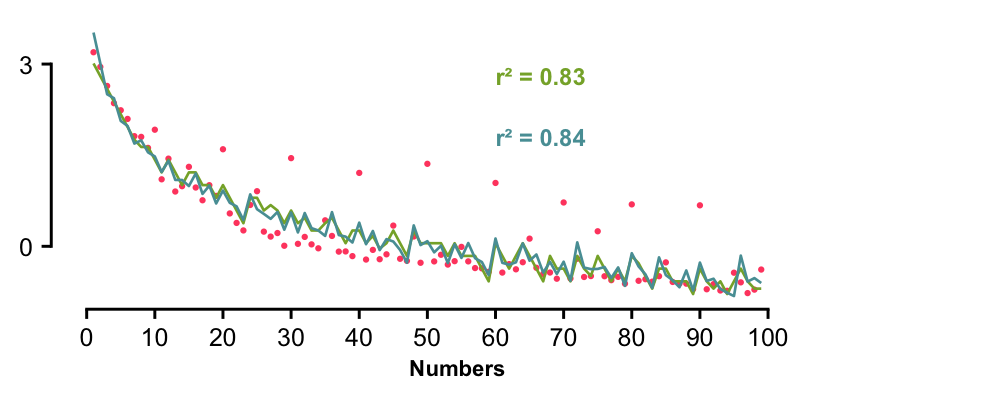

In [6]:
%%R  -w 5 -h 2 --units in -r 200
data <- read.csv('temp.csv')
R21 <- round(data$R2[1],2) 
R22 <- round(data$R2[2],2)
c1 = moma.colors('Klein',7)[1]
c2 = moma.colors('Klein',7)[2]
c3 = moma.colors('Klein',7)[5]
pl3 <- data %>%
    ggplot(aes(x = numbers)) +
    geom_point(aes(y = log_freq, color=c1),size=0.4, color=c1) +
    geom_line(aes(y = predictions_max, color=c2), linewidth=0.45, color=c3) +
    geom_line(aes(y = predictions_add, color=c3), linewidth=0.45, color=c2) +

    annotate("text", x = 60, y = 2.8, label = paste("r² =", R21), size = 3, hjust = 0, fontface = "bold", color=c3) +
    annotate("text", x = 60, y = 1.8, label = paste("r² =", R22), size = 3, hjust = 0, fontface = "bold", color=c2) +

    theme(legend.position = "none",
        axis.title.y=element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.x = element_text(face="bold", size=8, hjust=0.43, family='Arial')) +
    labs(x = "Numbers") +
    # scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/5_both_models.svg", pl3, device='svg',width = 8, height = 3, units = "in")
pl3


# Both models with approximation

In [7]:
w = 0.15
def gaussian(x):
    return(np.exp(-(x**2)))
approx_range = 100
def approx_numbers(n,approx_range):
    return [n-j for j in range(1,approx_range) if n-j>0] + [n+j for j in range(1,approx_range) if n+j<100]

In [8]:
def get_probs_add_approx(add_cost, mult_cost, f1, alpha):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1   
    # number_probs[5] = 300 
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] += number_probs[j]*number_probs[i-j]*add_cost
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i]+= number_probs[j]*number_probs[i//j]*mult_cost

    multiples_10 = [10*i for i in range(1,10)]
    for n in multiples_10:
        prob_appros = []
        for i in approx_numbers(n, approx_range):
            prob_appro = alpha*gaussian((np.log10(n) - np.log10(i))/w)
            number_probs[i] = (1-prob_appro)*number_probs[i]
            # print(i)
            # print(prob_appro)
            prob_appros.append(prob_appro)
        number_probs[n] =(1+sum(prob_appros))* number_probs[n]
    
    return np.log10(number_probs[1:100])



def get_probs_max_approx(add_cost, mult_cost, f1, alpha):
    number_probs = np.zeros(100)
    number_probs[0]=1
    number_probs[1] = f1    
    for i in range(1,100):
        if number_probs[i]==0:
            for j in range(1,i//2 +1):
                number_probs[i] = max(number_probs[i],number_probs[j]*number_probs[i-j]*add_cost) 
            for j in range(2, int(np.sqrt(i))+1):
                if i%j==0:
                    number_probs[i]= max(number_probs[i],number_probs[j]*number_probs[i//j]*mult_cost)

    multiples_10 = [10*i for i in range(1,10)]
    for n in multiples_10:
        prob_appros = []
        for i in approx_numbers(n, approx_range):
            prob_appro = alpha*gaussian((np.log10(n) - np.log10(i))/w)
            number_probs[i] = (1-prob_appro)*number_probs[i]
            # print(i)
            # print(prob_appro)
            prob_appros.append(prob_appro)
        number_probs[n] =(1+sum(prob_appros))* number_probs[n]
    return np.log10(number_probs[1:100])


def loss_function_max_approx(params, target_vector):
    add_cost, mult_cost, f1, alpha = params
    predictions = get_probs_max_approx(add_cost, mult_cost, f1, alpha)
    return np.sum((predictions - target_vector) ** 2)

def loss_function_add_approx(params, target_vector):
    add_cost, mult_cost, f1, alpha = params
    predictions = get_probs_add_approx(add_cost, mult_cost, f1, alpha)
    return np.sum((predictions - target_vector) ** 2)


In [13]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['en'])]
target = np.array(df['log_freq'])
freqs = df.corrected_total_freq
## we define the initial guess for the optimization as what would be 
##the parameters accounting for the first few numbers
## so that the initial guess is in the right neigborhood
initial_guess = [freqs[1]/freqs[0]/freqs[0], freqs[5]/freqs[1]/freqs[2], freqs[0],0.05]
##            = freq(2)/freq(1)^2             , freq(6)/(freq(2)*freq(3))    , freq(1) 


result_max_approx = minimize(loss_function_max_approx, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params_max_approx = result_max_approx.x
predictions_max_approx = get_probs_max_approx(*best_params_max_approx)
R2_max_approx = (r2_score(predictions_max_approx,df.log_freq))

result_add_approx = minimize(loss_function_add_approx, initial_guess, args=(target,), method = 'Nelder-Mead')
best_params_add_approx = result_add_approx.x
predictions_add_approx = get_probs_add_approx(*best_params_add_approx)
R2_add_approx = (r2_score(predictions_add_approx,df.log_freq))

numbers = [i+1 for i in range(99)]
preds = {
    'numbers':numbers,
    'log_freq': df.log_freq,
    'predictions_max_approx':predictions_max_approx,
    'predictions_add_approx':predictions_add_approx,

    'R2':[R2_max_approx, R2_add_approx] + [0]*(len(numbers)-2)

}
df3 = pd.DataFrame(preds)
df3.to_csv('temp.csv')

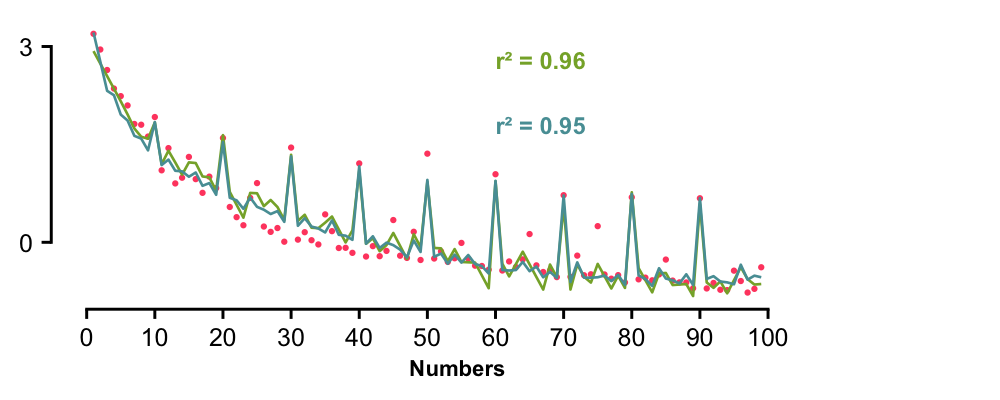

In [14]:
%%R  -w 5 -h 2 --units in -r 200
data <- read.csv('temp.csv')
R21 <- round(data$R2[1],2) 
R22 <- round(data$R2[2],2)
c1 = moma.colors('Klein',7)[1]
c2 = moma.colors('Klein',7)[2]
c3 = moma.colors('Klein',7)[5]
pl3 <- data %>%
    ggplot(aes(x = numbers)) +
    geom_point(aes(y = log_freq, color=c1),size=0.4, color=c1) +
    geom_line(aes(y = predictions_max_approx), linewidth=0.45, color=c3) +
    geom_line(aes(y = predictions_add_approx), linewidth=0.45, color=c2) +

    annotate("text", x = 60, y = 2.8, label = paste("r² =", R21), size = 3, hjust = 0, fontface = "bold", color=c3) +
    annotate("text", x = 60, y = 1.8, label = paste("r² =", R22), size = 3, hjust = 0, fontface = "bold", color=c2) +

    theme(legend.position = "none",
        axis.title.y=element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.x = element_text(face="bold", size=8, hjust=0.43, family='Arial')) +
    labs(x = "Numbers") +
    # scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/6_both_models_with_approx.svg", pl3, device='svg',width = 8, height = 3, units = "in")
pl3


In [15]:
df3.drop('R2', axis =1, inplace=True)
all = pd.merge(df2, df3)
features = ['log10', 'mult10', 'mult5', 'mult3', 'mult2', 'mult7']
models = ["predictions_max", "predictions_add", "predictions_max_approx", "predictions_add_approx"]

def format_number(x, size=3):
    if pd.isnull(x):
        return ""
    if abs(x) < 0.001:
        return f"{x:.2E}"  # scientific notation like 3E-5
    else:
        return f"{x:.{size}f}".rstrip('0').rstrip('.')
    
header_row1 = ['Language', 'r²'] + [feat.capitalize() for feat in features for _ in (0, 1)]
header_row2 = ['', ''] + ['β' if i % 2 == 0 else 'P-value' for i in range(len(features) * 2)]
data_rows = []

for lang in models:
    df = data[data.lang == 'en']
    X = df[features]
    y = all[lang]  # Update if needed
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()

    row = [lang, format_number(model.rsquared)]
    
    for feat in features:
        row.append(format_number(model.params[feat], size=2))
        row.append(format_number(model.pvalues[feat]))
    
    data_rows.append(row)

# Create the DataFrame with multi-header style
final_df = pd.DataFrame([header_row1, header_row2] + data_rows)

# Save
final_df.to_csv('tables/models_regression_formatted.csv', index=False, header=False)
final_df.to_excel('tables/models_regression_formatted.xlsx', index=False, header=False)